#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization
from keras.backend import clear_session
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [5]:
data1 = pd.read_csv(path + '/data01_train.csv')
data1.drop('subject', axis=1, inplace=True)
data1.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [6]:
data2 = pd.read_csv(path + '/data01_test.csv')
data2.drop('subject', axis=1, inplace=True)
data2.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


In [7]:
data3 = pd.read_csv(path + '/features.csv')
data3.head()

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


#### 2) 기본 정보 조회

In [8]:
print('train : ', data1.shape)
print('test : ', data2.shape)
print('features : ', data3.shape)

train :  (5881, 562)
test :  (1471, 562)
features :  (561, 4)


In [9]:
print(data1.isna().sum())
print('*' * 20)
print(data2.isna().sum())

tBodyAcc-mean()-X                       0
tBodyAcc-mean()-Y                       0
tBodyAcc-mean()-Z                       0
tBodyAcc-std()-X                        0
tBodyAcc-std()-Y                        0
                                       ..
angle(tBodyGyroJerkMean,gravityMean)    0
angle(X,gravityMean)                    0
angle(Y,gravityMean)                    0
angle(Z,gravityMean)                    0
Activity                                0
Length: 562, dtype: int64
********************
tBodyAcc-mean()-X                       0
tBodyAcc-mean()-Y                       0
tBodyAcc-mean()-Z                       0
tBodyAcc-std()-X                        0
tBodyAcc-std()-Y                        0
                                       ..
angle(tBodyGyroJerkMean,gravityMean)    0
angle(X,gravityMean)                    0
angle(Y,gravityMean)                    0
angle(Z,gravityMean)                    0
Activity                                0
Length: 562, dtype: int64


## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


In [10]:
def model_pipeline(data, model, callbacks=None, cnt = 5):
  target = 'Activity'

  x = data.drop(target, axis=1)
  y = data.loc[:, target]

  # x 스케일링
  scaler = MinMaxScaler()
  x = scaler.fit_transform(x)

  # y 전처리
  encoder = LabelEncoder()
  y_encoded = encoder.fit_transform(y)

  # 데이터 분할
  x_train, x_val, y_train, y_val = train_test_split(x, y_encoded, test_size=.2, random_state = 20)

  model_result = []

  total_score = 0

  # 모델 실행
  for _ in range(cnt):
    model.compile(optimizer=Adam(learning_rate=0.01), loss= 'sparse_categorical_crossentropy')
    history = model.fit(x_train, y_train, epochs = 50, validation_split=0.2, verbose = 0, callbacks=callbacks).history

    pred1 = model.predict(x_val)
    pred_1 = pred1.argmax(axis=1)
    total_score += accuracy_score(y_val, pred_1)


  dl_history_plot(history)
  print(classification_report(y_val, pred_1))

  return total_score / cnt

### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [11]:
target = 'Activity'

x = data1.drop(target, axis=1)
y = data1.loc[:, target]

### (2) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [12]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [13]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded[:5]

### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [14]:
x_train, x_val, y_train, y_val = train_test_split(x, y_encoded, test_size=.2, random_state = 20)

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1

In [15]:
nfeatures = data1.shape[1] - 1
nfeatures

561

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


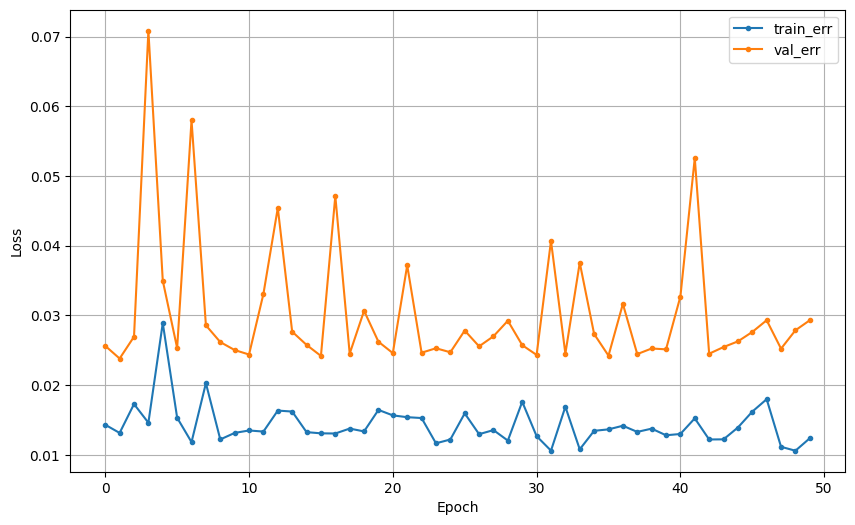

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       0.95      0.94      0.95       211
           2       0.94      0.95      0.95       214
           3       0.99      1.00      0.99       203
           4       1.00      0.99      1.00       170
           5       0.99      0.99      0.99       177

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

model score: 0.97892948173322


In [16]:
clear_session()
model1 = Sequential([Input(shape = (nfeatures,)),
                     Dense(6, activation = 'softmax')])

print(f'model score: {model_pipeline(data1, model1)}')

### (2) 모델2

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


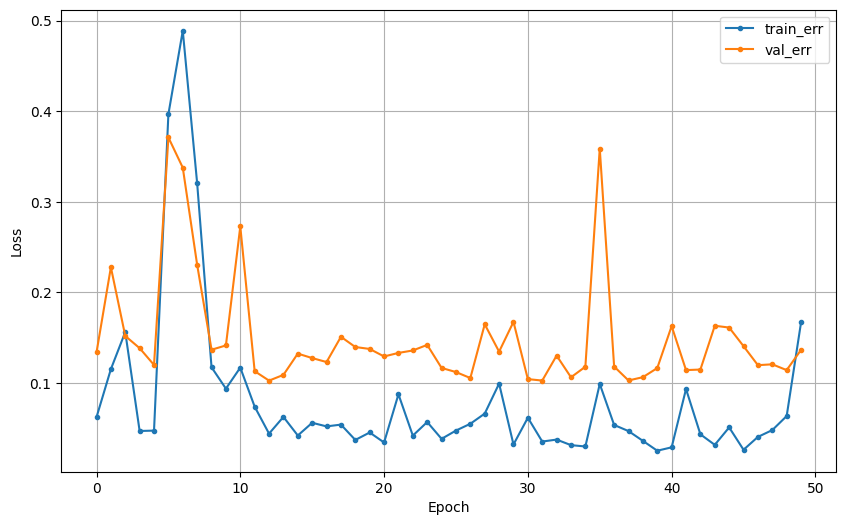

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       0.96      0.92      0.94       211
           2       0.93      0.97      0.95       214
           3       0.94      1.00      0.96       203
           4       0.95      0.87      0.91       170
           5       0.87      0.88      0.87       177

    accuracy                           0.94      1177
   macro avg       0.94      0.94      0.94      1177
weighted avg       0.94      0.94      0.94      1177

model2 score: 0.9177570093457945


In [17]:
clear_session()
model2 = Sequential([Input(shape = (nfeatures, )),
                     Dense(128, activation = 'relu'),
                     Dense(64, activation = 'relu'),
                     Dense(32, activation = 'relu'),
                     Dense(16, activation = 'relu'),
                     Dense(8, activation = 'relu'),
                     Dense(6, activation = 'softmax')
                     ])
print(f'model2 score: {model_pipeline(data1, model2)}')

### (3) 모델3

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


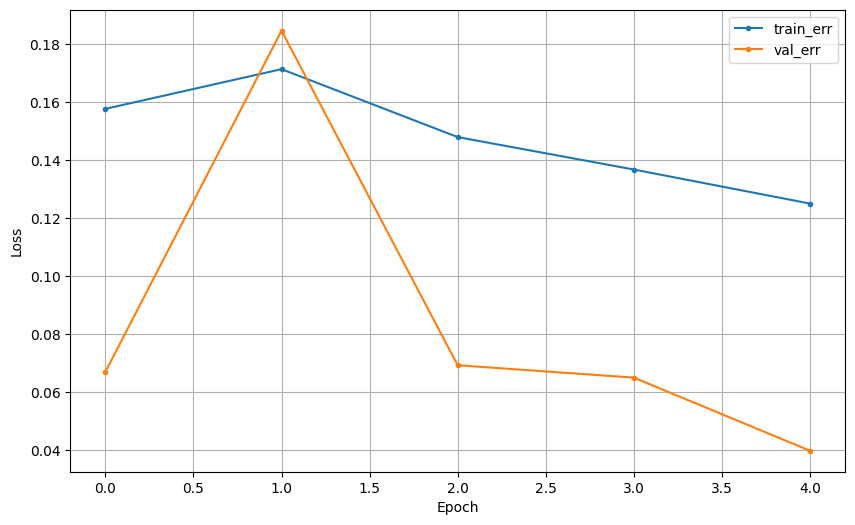

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       0.95      0.96      0.96       211
           2       0.96      0.95      0.96       214
           3       1.00      1.00      1.00       203
           4       1.00      0.99      1.00       170
           5       0.99      0.99      0.99       177

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

model3 score: 0.9726423109600679


In [18]:
clear_session()

dropout_num = 0.2

model3 = Sequential([Input(shape = (nfeatures, )),
                     Dense(128, activation = 'relu'),
                     BatchNormalization(),
                     Dropout(dropout_num),
                     Dense(64, activation = 'relu'),
                     BatchNormalization(),
                     Dropout(dropout_num),
                     Dense(32, activation = 'relu'),
                     BatchNormalization(),
                     Dropout(dropout_num),
                     Dense(16, activation = 'relu'),
                     BatchNormalization(),
                     Dropout(dropout_num),
                     Dense(8, activation = 'relu'),
                     BatchNormalization(),
                     Dropout(dropout_num),
                     Dense(6, activation = 'softmax')
                     ])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
min_de = 0.005
pat = 5
es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = pat)

print(f'model3 score: {model_pipeline(data1, model3, callbacks=[es, lr_scheduler])}')

### (4) 모델4

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


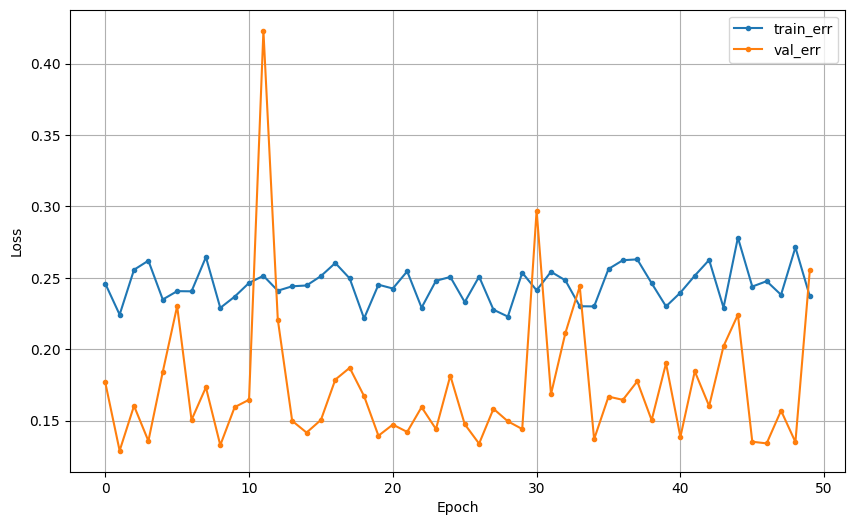

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       0.83      0.92      0.87       211
           2       0.92      0.81      0.86       214
           3       0.98      0.80      0.88       203
           4       0.95      0.94      0.95       170
           5       0.81      0.99      0.89       177

    accuracy                           0.91      1177
   macro avg       0.91      0.91      0.91      1177
weighted avg       0.92      0.91      0.91      1177

model4 score: 0.9191163976210707


In [19]:
n_data = data1[['tGravityAcc-min()-X', 'tGravityAcc-mean()-X', 'tGravityAcc-mean()-Y',
 'tGravityAcc-energy()-X', 'angle(X,gravityMean)', 'tGravityAcc-max()-X',
 'tGravityAcc-max()-Y', 'tGravityAcc-min()-Y', 'angle(Y,gravityMean)',
 'tGravityAcc-min()-Z', 'fBodyAccMag-std()', 'angle(Z,gravityMean)',
 'tBodyAccJerk-sma()', 'tBodyAccJerkMag-mean()', 'tBodyAccMag-std()',
 'tGravityAcc-energy()-Y', 'fBodyAccJerk-bandsEnergy()-1,16',
 'tGravityAcc-arCoeff()-Z,1', 'fBodyAccJerk-bandsEnergy()-1,8',
 'fBodyAccJerk-energy()-X', 'Activity']]

nfeatures = n_data.shape[1] - 1
nfeatures

model4 = Sequential([Input(shape = (nfeatures, )),
                     Dense(128, activation = 'relu'),
                     BatchNormalization(),
                     Dropout(dropout_num),
                     Dense(64, activation = 'relu'),
                     BatchNormalization(),
                     Dropout(dropout_num),
                     Dense(32, activation = 'relu'),
                     BatchNormalization(),
                     Dropout(dropout_num),
                     Dense(16, activation = 'relu'),
                     BatchNormalization(),
                     Dropout(dropout_num),
                     Dense(8, activation = 'relu'),
                     BatchNormalization(),
                     Dropout(dropout_num),
                     Dense(6, activation = 'softmax')
                     ])

print(f'model4 score: {model_pipeline(n_data, model4)}')

## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [20]:
test_data = data2.copy()
test_x = test_data.drop('Activity', axis=1)
test_y = test_data.loc[:, 'Activity']

scaler = MinMaxScaler()
test_x = scaler.fit_transform(test_x)

encoder = LabelEncoder()
test_y_encoded = encoder.fit_transform(test_y)

In [21]:
test_pred1 = model1.predict(test_x)
test_pred_1 = test_pred1.argmax(axis=1)

print(accuracy_score(test_y_encoded, test_pred_1))
print(classification_report(test_y_encoded, test_pred_1))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
0.9605710401087696
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       292
           1       0.96      0.85      0.90       254
           2       0.88      0.98      0.93       287
           3       0.96      1.00      0.98       228
           4       0.99      1.00      0.99       195
           5       1.00      0.95      0.97       215

    accuracy                           0.96      1471
   macro avg       0.97      0.96      0.96      1471
weighted avg       0.96      0.96      0.96      1471



In [22]:
test_pred2 = model2.predict(test_x)
test_pred_2 = test_pred2.argmax(axis=1)

print(accuracy_score(test_y_encoded, test_pred_2))
print(classification_report(test_y_encoded, test_pred_2))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
0.9089055064581917
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       292
           1       0.99      0.79      0.88       254
           2       0.84      0.99      0.91       287
           3       0.83      1.00      0.91       228
           4       0.99      0.85      0.91       195
           5       0.85      0.78      0.81       215

    accuracy                           0.91      1471
   macro avg       0.92      0.90      0.90      1471
weighted avg       0.92      0.91      0.91      1471



In [23]:
test_pred3 = model3.predict(test_x)
test_pred_3 = test_pred3.argmax(axis=1)

print(accuracy_score(test_y_encoded, test_pred_3))
print(classification_report(test_y_encoded, test_pred_3))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
0.964649898028552
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.94      0.93      0.94       254
           2       0.94      0.95      0.94       287
           3       0.97      1.00      0.98       228
           4       0.94      1.00      0.97       195
           5       1.00      0.91      0.95       215

    accuracy                           0.96      1471
   macro avg       0.96      0.96      0.96      1471
weighted avg       0.97      0.96      0.96      1471

